### **torch实现LeNet**

**LeNet的简化架构**

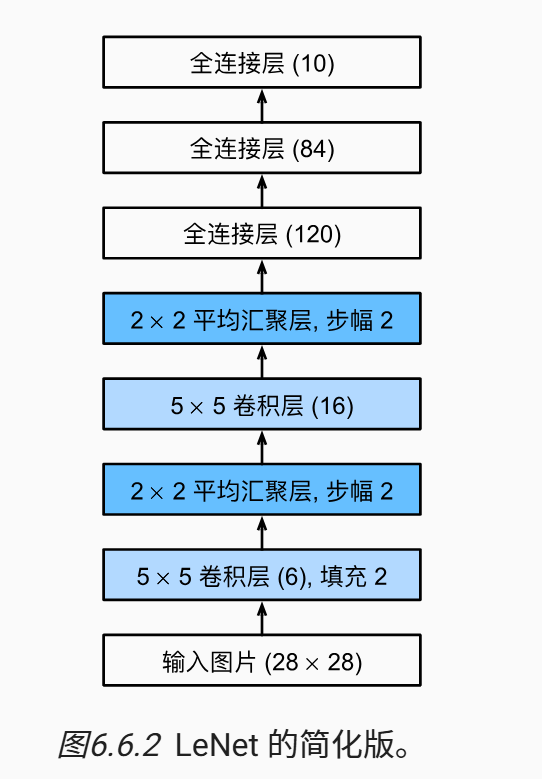

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。

In [96]:
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
from mnist import load_mnist # 我想用mnist的手写数字数据集尝试
from torch import optim
import numpy as np

In [97]:
# 构造torch的数据迭代器
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """
    构造一个PyTorch数据迭代器
    data_arrays : 一个元组，tensor格式
    batch_size : 批大小，当数据量不够整除时，最后的是余数大小的数据
    """
    dataset = data.TensorDataset(*data_arrays) # 生成数据集
    return data.DataLoader(dataset, batch_size, shuffle=is_train) # 返回迭代器

In [98]:
# 本模型采用Xavier随机初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)

In [99]:
# 定义超参数
nums_epoch = 10
learning_rate = 0.9
weight_delay = 0

# 定义网络
"""输入单个数据大小为1 x 28 x 28"""
net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size = 5,padding = 2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2,stride = 2),
    nn.Conv2d(6,16,kernel_size = 5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2,stride = 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10),
)
net.apply(init_weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = learning_rate,weight_decay = weight_delay)

In [100]:
# 可视化输入数据进入每层网络后的shape
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [101]:
# 读取数据集
(x_train,y_train),(x_test,y_test) = load_mnist(normalize = True,flatten = False,one_hot_label = True)
print(x_train.shape)
print(y_train.shape)
print(type(x_train))

(60000, 1, 28, 28)
(60000, 10)
<class 'numpy.ndarray'>


In [102]:
x_train = torch.tensor(x_train,dtype = torch.float32)
y_train = torch.tensor(y_train,dtype = torch.float32)
x_test = torch.tensor(x_test,dtype = torch.float32)
y_test = torch.tensor(y_test,dtype = torch.float32)
train_iter = load_array((x_train,y_train),batch_size = 256,is_train = True)
test_iter = load_array((x_test,y_test),batch_size = 256,is_train = False)

In [103]:
# 评估准确率的函数
def accurancy_check(data_iter):
    all_nums = 0
    correct = 0
    for x,y in data_iter:
        y_pred = net(x)
        y_pred = torch.argmax(y_pred,dim = 1)
        y = torch.argmax(y,dim = 1)
        all_nums += len(y)
        correct += torch.sum(y_pred == y)
    return correct / all_nums
        

In [104]:
# 训练函数
plt_loss = []
acc_train = []
acc_test = []
def train(train_iter,test_iter,nums_epoch,loss_show = None):
    plt_loss.clear()
    for epoch in range(nums_epoch):
        for x,y in train_iter:
            optimizer.zero_grad()
            y_pred = net(x)
            loss = loss_fn(y_pred,y)
            loss.backward()
            optimizer.step()
        if loss_show != None:
            plt_loss.append(loss_fn(net(loss_show[0]),loss_show[1]))
        acc_train.append(accurancy_check(train_iter))
        acc_test.append(accurancy_check(test_iter))
        print(f"{epoch + 1} finish!")


In [105]:
train(train_iter,test_iter,10,(x_train,y_train))

1 finish!
2 finish!
3 finish!
4 finish!
5 finish!
6 finish!
7 finish!
8 finish!
9 finish!
10 finish!


In [108]:
for i in plt_loss:
    print(i)

for i in range(nums_epoch):
    print(acc_train[i],acc_test[i])

tensor(2.3089, grad_fn=<DivBackward1>)
tensor(2.3023, grad_fn=<DivBackward1>)
tensor(2.3026, grad_fn=<DivBackward1>)
tensor(2.3014, grad_fn=<DivBackward1>)
tensor(2.0509, grad_fn=<DivBackward1>)
tensor(0.4758, grad_fn=<DivBackward1>)
tensor(0.4250, grad_fn=<DivBackward1>)
tensor(0.2150, grad_fn=<DivBackward1>)
tensor(0.1574, grad_fn=<DivBackward1>)
tensor(0.1390, grad_fn=<DivBackward1>)
tensor(0.1124) tensor(0.1135)
tensor(0.1022) tensor(0.1010)
tensor(0.1124) tensor(0.1135)
tensor(0.0993) tensor(0.1032)
tensor(0.3474) tensor(0.3589)
tensor(0.8500) tensor(0.8562)
tensor(0.8440) tensor(0.8474)
tensor(0.9345) tensor(0.9358)
tensor(0.9531) tensor(0.9531)
tensor(0.9582) tensor(0.9583)


**成功了，模型在mnist数据集上没有过拟合，且识别准确度高**